In [11]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from importlib import reload
from scipy.linalg import solve_banded
reload(plt)
%matplotlib notebook

from numba import njit
from scipy.linalg import solve_banded

In [217]:
def u(x, y ,t):
    return (1 + x * y + ((np.exp(t) - np.exp((-np.pi ** 2)*t)) / (1 + np.pi ** 2)) 
            * np.cos(np.pi * x / 2) * np.sin(np.pi * y / 2))

def u_t_0(x, y):
    return 1 + x * y

def u_x_0(y, t):
    return 1 + (np.exp(t) - np.exp(-np.pi **2 *t)) * np.sin(np.pi * y / 2) / (1 + np.pi ** 2)

def u_y_0(x, t):
    return 1

def u_x_1(y, t):
    return 1 + y

def u_y_1(x, t):
    return 1 + x + (np.exp(t) - np.exp(-np.pi ** 2 * t)) * np.cos(np.pi * x / 2) / (1 + np.pi ** 2)


a = 2
def f(x, y, t):
    return np.exp(t) * np.cos(np.pi * x / 2) * np.sin(np.pi * y / 2)

In [304]:
def lambda1(arr, i, j, k, h):
        return (arr[i + 1, j, k] - 2 * arr[i, j, k] + arr[i - 1, j, k]) / h ** 2

def lambda2(arr, i, j, k, h):
    return (arr[i, j + 1, k] - 2 * arr[i, j, k] + arr[i, j - 1, k]) / h ** 2 

def solve_ADI(tau, h, u_t_0, u_x_0, u_x_1, u_y_0, u_y_1, f, a, T):
    N = math.ceil(1 / h) + 1;
    K = math.ceil(T / tau) + 1;
    
    y = np.zeros(shape=(N, N, K))
    x = np.linspace(0, 1, N)
    t = np.linspace(0, T, K)
    xx, yy, tt = np.meshgrid(x, x, t, indexing='ij')

    y[:,:,0] = u_t_0(xx[:,:,0], yy[:,:,0])
    y[0,:,:] = u_x_0(yy[0,:,:], tt[0,:,:])
    y[-1,:,:] = u_x_1(yy[-1,:,:], tt[-1,:,:])
    y[:,0,:] = u_y_0(xx[:,0,:], tt[:,0,:])
    y[:,-1,:] = u_y_1(xx[:, -1, :], tt[:, -1, :])
    
    y_temp = np.zeros((N, N, K - 1))
    
    A = np.zeros(shape=(3, N - 2))
    A[0, 1:] = - a / 2 
    A[2, :-1] =  - a / 2 
    A[1, :] = h ** 2 / tau + a
        
    for k in range(K - 1):
        
        for j in range(1, N - 1):
            y_temp[0, j, k] = (y[0, j, k + 1] + y[0, j, k]) / 2 \
            - tau * a * (lambda2(y, 0, j, k+1, h) - lambda2(y, 0, j, k, h)) / 4
            y_temp[-1, j, k] = (y[-1, j, k+1] + y[-1, j, k]) / 2 \
            - tau * a * (lambda2(y, -1, j, k+1, h) - lambda2(y, -1, j, k, h)) / 4
            
            b = h ** 2 / tau * y[1:-1, j, k] + h ** 2 * f(x[1:-1], x[j], k * tau + tau / 2) / 2 \
                 + h**2 * a * lambda2(y, range(1, N - 1), j, k, h) / 2
            
            b[0] += y_temp[0, j, k] * a / 2
            b[-1] += y_temp[-1, j, k] * a / 2
            
            y_temp[1:-1, j, k] = solve_banded((1,1), A, b)
        
        
        
        for i in range(1, N - 1):
            b = h ** 2 / tau * y_temp[i, 1:-1, k] + h ** 2 * f(x[i], x[1:-1], k * tau + tau / 2) / 2 \
                 + h ** 2 * a * lambda1(y_temp, i, range(1, N - 1), k, h) / 2
            
            b[0] += y[i, 0, k+1] * a / 2
            b[-1] += y[i, -1, k+1] * a /2 
            
            y[i, 1:-1, k + 1] = solve_banded((1,1), A, b)
            
    
    return y

In [305]:
h = 0.1
tau = 0.1
T = 1

a = 2
y = solve_ADI(tau, h, u_t_0, u_x_0, u_x_1, u_y_0, u_y_1, f, a, T)


In [308]:
def plot(y, u, h, T, title):
    N = y.shape[1]
    X = h * np.arange(N)
    XX1, XX2 = np.meshgrid(X, X, indexing='ij')

    Z = u(XX1, XX2, T)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(XX1, XX2, Z, label='original solution"')
    surf._edgecolors2d= surf._edgecolors3d
    surf._facecolors2d= surf._facecolors3d
    
    ax.scatter3D(XX1, XX2, y[:,:,-1], c='Red', s=1, label='numerical solution');
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.set_title(title);
    ax.legend(loc ='lower right')

<IPython.core.display.Javascript object>


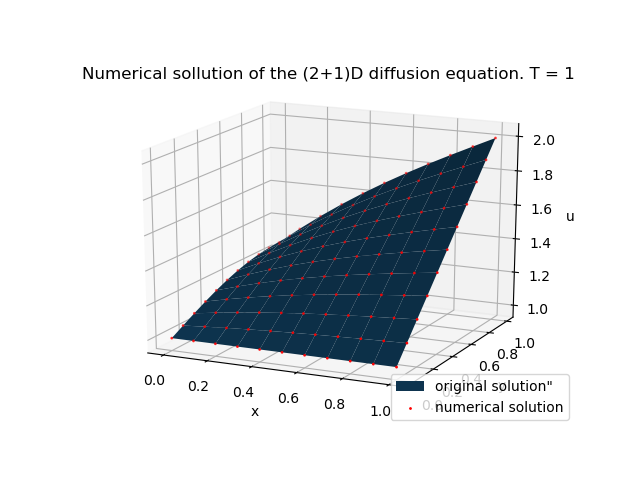

(11, 11, 11)


In [307]:
plot(y, u, h, T, "Numerical sollution of the (2+1)D diffusion equation. T = 1")